# Mini Competition: Richter's Predictor

Import modules and data

In [19]:
# install from requirements
!pip install -r requirements_petr.txt

In [2]:
# Modules
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
# Import scripts
import visualisation_functions 
import helper_functions # various helper functions
import lgb_optimized_petr # 

In [4]:
# Load data
X, y, X_test = helper_functions.imports()

Data Analysis

Data Cleaning

In [5]:
#First cleaning (before split - if required)

In [6]:
y = y['damage_grade']

In [7]:
# Split data in training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
#More cleaning (after split)

Visualization

<Axes: title={'center': 'Feature Correlation Heatmap'}>

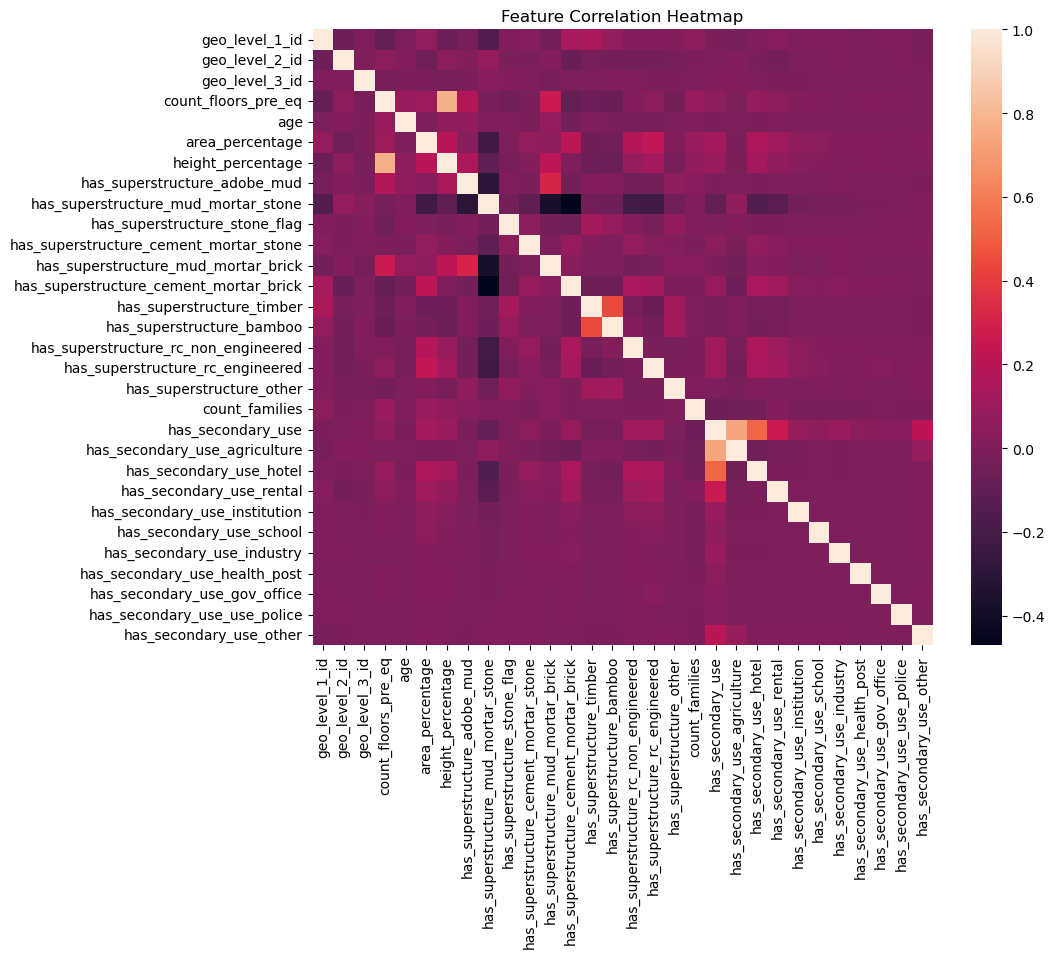

In [9]:
# correlation heatmap of predictors
corr = X.select_dtypes(include=[np.number]).drop('building_id', axis=1).corr()
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title("Feature Correlation Heatmap")
sns.heatmap(corr, ax=ax)

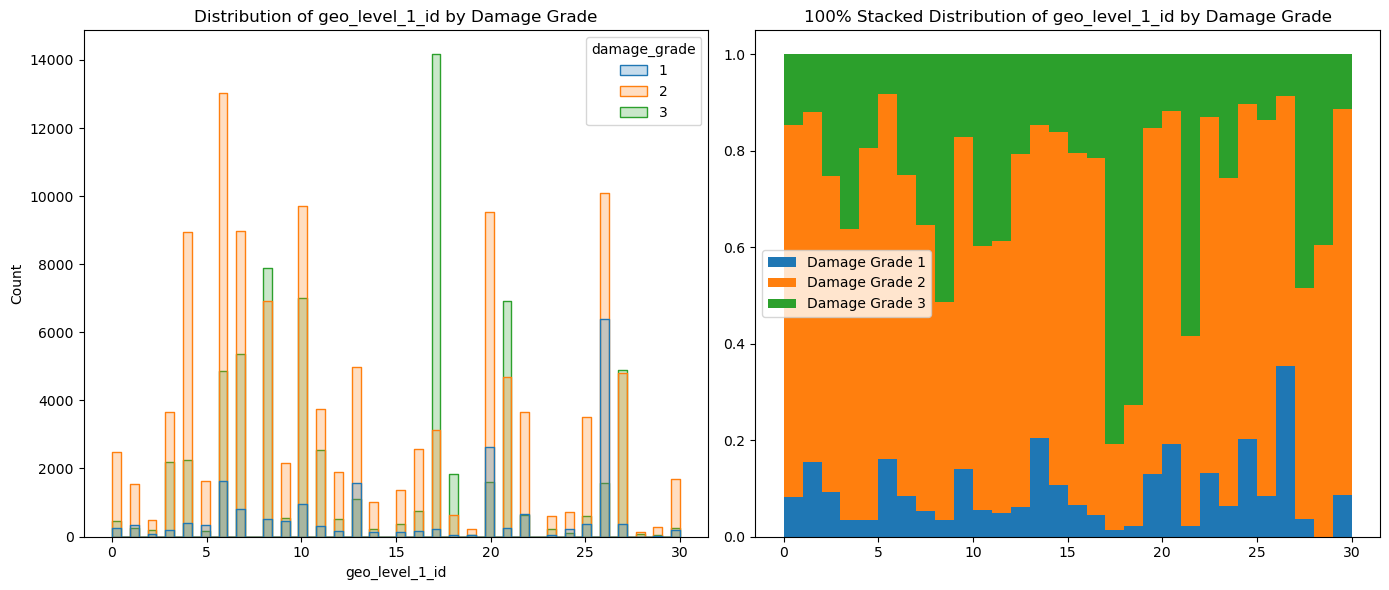

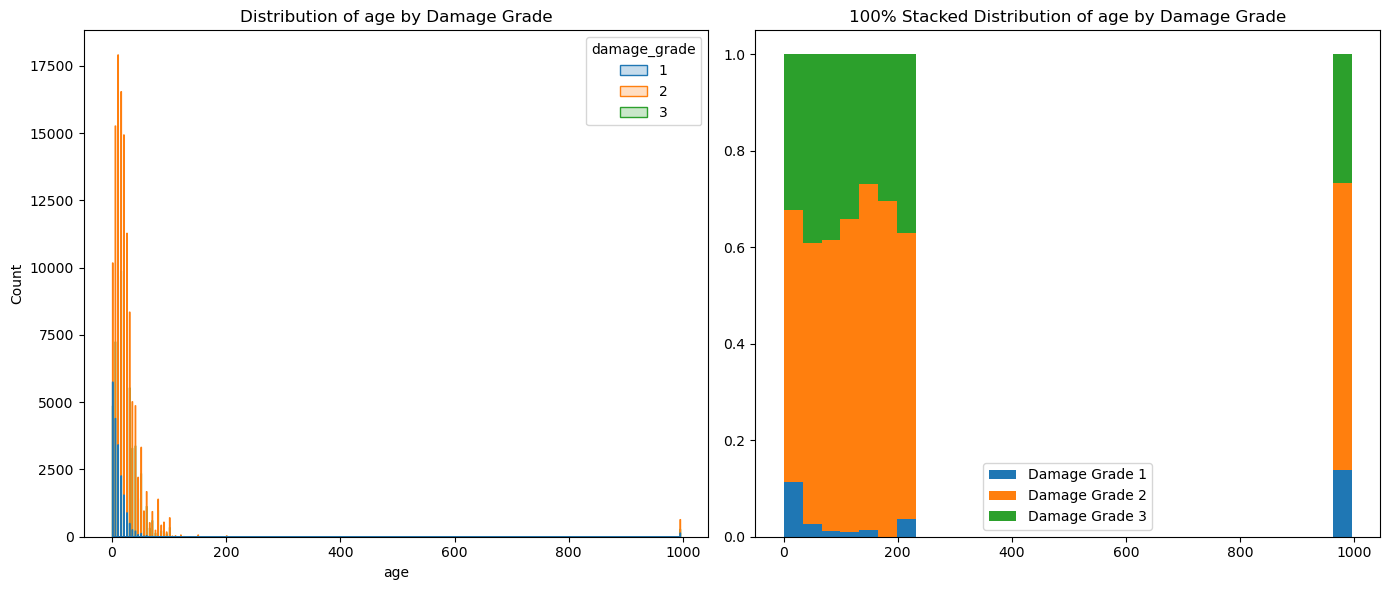

In [10]:
# for each predictor, show histogram and 100% stacked histogram  
visualisation_functions.hist2x2_f(X_train,y_train,cols_include=['geo_level_1_id','age'],cols_ignore=[])

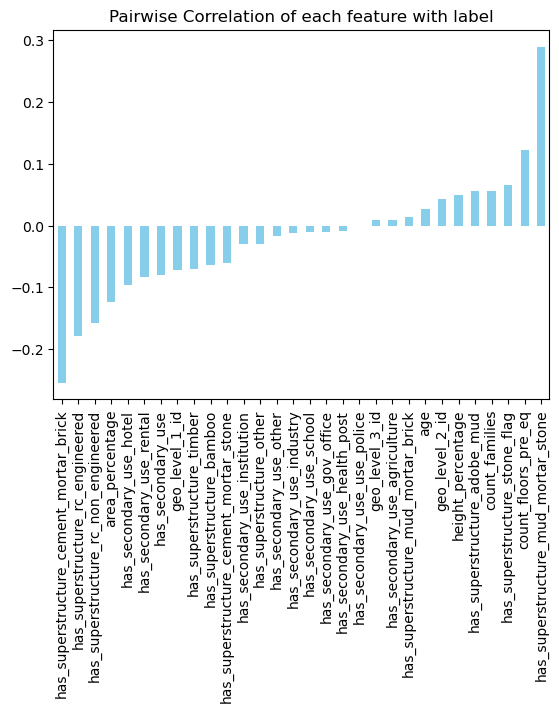

In [11]:
# pairwise correlation
# Concatenate X_train and y for correlation calculation
visualisation_functions.plot_pairwise_cor(X_train,y)

Generation of Random Forest and optimization

In [12]:
#FOR NOW (to test tree gen) limit dataset to a few parameters only
mask = ['has_superstructure_adobe_mud', 'age','count_floors_pre_eq','area_percentage','height_percentage','has_secondary_use',
        'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo'] 


# apply mask
X = X[mask]

X_train = X_train[mask]
X_valid = X_valid[mask]

# Cut off 'building_id' from X_test!
X_test_pred = X_test[mask]

In [13]:
# Initiate model
model = lgb_optimized_petr.LGBM(X_train, X_valid, y_train, y_valid)

In [14]:
# Generate and optimize Random Forest, feed with test data to create prediction
model.optimization(X=X, y=y,optuna_n_trials=2) # run model fit and optimize hyperparameters


[I 2023-10-06 19:29:09,701] A new study created in memory with name: no-name-a45c2137-99af-4081-a1a7-ebbe191f0a6c


[I 2023-10-06 19:29:13,684] Trial 0 finished with value: 0.30093436426776154 and parameters: {'learning_rate': 0.26271551125948217, 'subsample': 0.7794057539577378, 'num_leaves': 12, 'min_data_in_leaf': 5, 'max_depth': 7, 'lambda_l2': 0.7120386819985063}. Best is trial 0 with value: 0.30093436426776154.
[I 2023-10-06 19:29:17,854] Trial 1 finished with value: 0.3013948312580342 and parameters: {'learning_rate': 0.12126531865218947, 'subsample': 0.7475440478035984, 'num_leaves': 41, 'min_data_in_leaf': 16, 'max_depth': 9, 'lambda_l2': 0.4213448754640644}. Best is trial 1 with value: 0.3013948312580342.


Number of finished trials: 2
Best trial:
--------------------------------
Best F1 Score: 0.3013948312580342
--------------------------------
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] lambda_l2 is set=0.4213448754640644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4213448754640644
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] lambda_l2 is set=0.4213448754640644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4213448754640644
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 157
[LightGBM] [Info] Number of data points in the train set: 260601, number of used feature

In [15]:
# create and save predictions 
y_pred=model.predict_f(X_test_pred)

[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] lambda_l2 is set=0.4213448754640644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4213448754640644


In [16]:
# summary statistics of predicted values
(y_pred.mean(),y_pred.std())

(2.042363125661924, 0.3389175787997147)

Evaluation

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

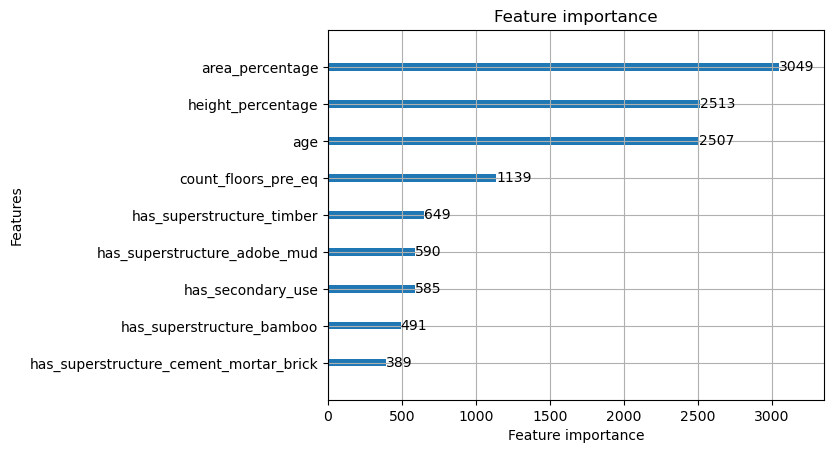

In [17]:
# feature importance default plot
fitted_model=model.get_model()
lgb.plot_importance(fitted_model)

# describe which importance measure it is -- perhaps add as argument to function

In [20]:
# feature importance sns plot - not used
#feature_imp_df=model.feature_importance_table()
#visualisation_functions.plot_feature_imp(feature_imp_df)


Export

In [ ]:
# Export prediction to creat csv by DrivenData.org datastandards
helper_functions.write_output(X_test, y_pred)